## Import the libraries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import KFold
from collections import Counter
import seaborn as sns
import pandas as pd
import kagglehub
from skimage.transform import resize 
from collections import defaultdict




## Load the Dataset from kaggle



In [3]:

dataset_path = kagglehub.dataset_download("ashishsaxena2209/animal-image-datasetdog-cat-and-panda")

100%|██████████| 376M/376M [00:03<00:00, 128MB/s]

Extracting files...


This cell loads the first 100 grayscale images from each of the three categories (cats, dogs, panda) in the dataset. Each image is resized to 32×32 pixels and stored in the X array, while corresponding labels (0 for cats, 1 for dogs, 2 for pandas) are stored in the y array. Finally, it converts both lists into NumPy arrays and prints their shapes.

In [4]:

dirs = ['cats', 'dogs', 'panda']
X = []
y = []
img_size = (32, 32)

for i, dir in enumerate(dirs):
    dir_path = os.path.join(dataset_path, 'animals', dir)
    paths = sorted(os.listdir(dir_path))[:100]  # First 100 images per class

    for file in paths:
        full_path = os.path.join(dir_path, file)
        try:
            img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                resized_img = cv2.resize(img, img_size)
                X.append(resized_img)
                y.append(i)
            else:
                print(f"Failed to load {full_path}")
        except Exception as e:
            print(f"Skipped {full_path}: {e}")

X = np.array(X)
y = np.array(y)

print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

Shape of X: (300, 32, 32), Shape of y: (300,)


## Shuffle Images
This cell randomly shuffles the dataset, selects 25 images, and displays them in a 5×5 grid using matplotlib. Instead of class names, it shows the numeric labels:

0 for cats

1 for dogs

2 for pandas






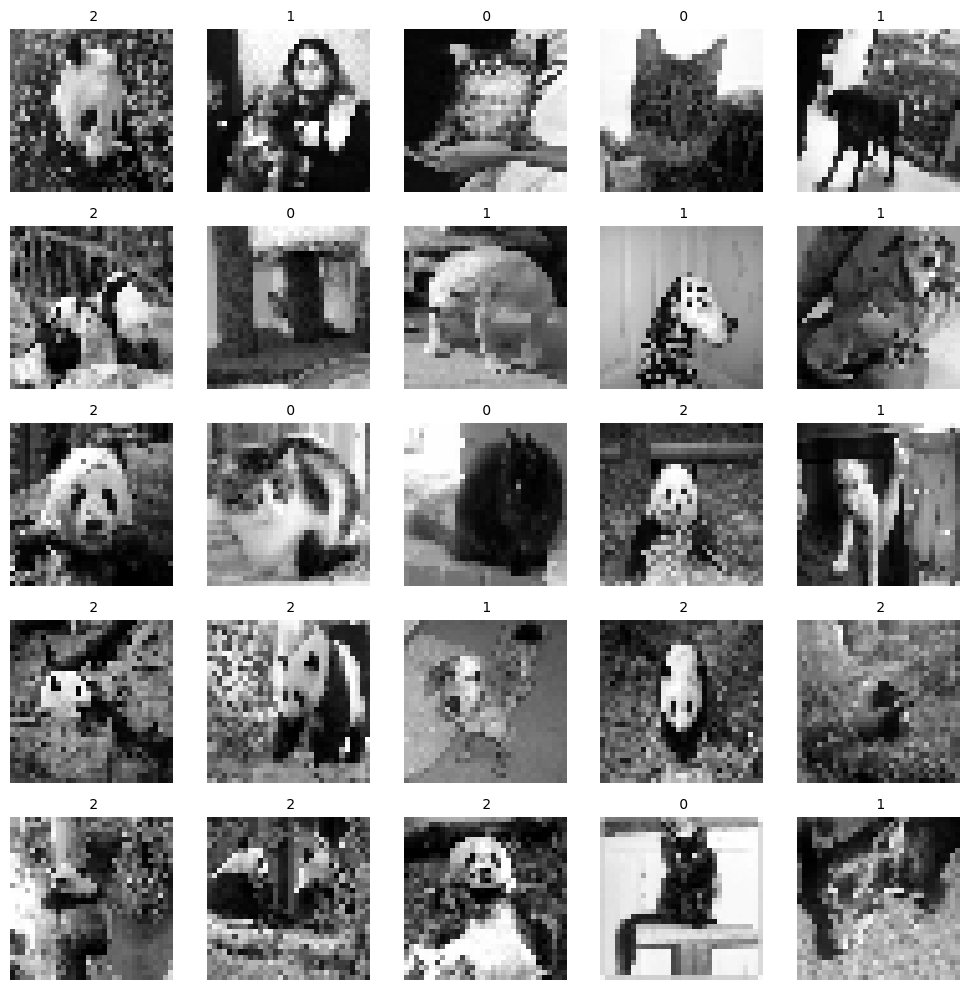

In [5]:
# Shuffle the dataset
indices = np.random.permutation(len(X))
X_shuffled = X[indices]
y_shuffled = y[indices]

# Display 25 random images with numeric labels
rows, cols = 5, 5
plt.figure(figsize=(10, 10))

for i in range(rows * cols):
    img = X_shuffled[i]
    label = y_shuffled[i]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap='gray', interpolation='nearest')
    plt.title(f" {label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Distance functions

Manhattan (L1) distance:
$$
D_{\text{L1}}(\mathbf{x}, \mathbf{y}) = \sum_{i=1}^{n} |x_i - y_i|
$$

Euclidean (L2) distance:
$$
D_{\text{L2}}(\mathbf{x}, \mathbf{y}) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}
$$


In [6]:
# Define distance functions
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

distance_functions = {
    'euclidean': euclidean_distance,
    'manhattan': manhattan_distance
}

## KNN Classifier

The `KNNClassifier` class implements the k-Nearest Neighbors algorithm for classification. It takes training data `X_train` and labels `y_train`, along with a `distance_metric` to compute similarity between points. The `predict` method classifies a new point `x` by finding its `K` nearest neighbors, voting on their labels, and returning the predicted class along with a confidence score (proportion of agreeing neighbors). The distance metric can be customized (e.g., Euclidean, Manhattan) via `distance_functions`.

In [7]:


class KNNClassifier:
    def __init__(self, X_train, y_train, distance_metric):
        self.X_train = X_train
        self.y_train = y_train
        self.distance_fn = distance_functions[distance_metric]

    def predict(self, x, K=5):
        distances = np.array([self.distance_fn(x, x_train) for x_train in self.X_train])
        nearest_indices = np.argpartition(distances, K)[:K]
        nearest_labels = self.y_train[nearest_indices]

        pred_label = np.bincount(nearest_labels).argmax()
        confidence = np.sum(nearest_labels == pred_label) / K

        return pred_label, confidence

## Evaluation Setup
The evaluation tests the `KNNClassifier` with different `K` values ([5, 10, 15, 20, 25]) and distance metrics (`euclidean` and `manhattan`) using `5-fold` cross-validation. Results are stored in a nested dictionary results, while a `confusion_matrix` (3×3) tracks classification performance. Additionally, `top_N` (with `N=5`) is used to store the best-performing configurations based on accuracy or other metrics. This setup allows for a comprehensive comparison of model performance across hyperparameters.

In [8]:

# Evaluation parameters
K_values = [5,10, 15, 20,25]
n_splits = 5
distance_metrics = ['euclidean', 'manhattan']
results = {metric: {k: [] for k in K_values} for metric in distance_metrics}
confusion_matrix = np.zeros((3, 3), dtype=np.int32)
top_N = []
N = 5

In [9]:

# K-Fold Cross Validation
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1337)

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    for metric_name in distance_metrics:
        knn = KNNClassifier(X_train, y_train, metric_name)

        for K in K_values:
            correct = 0
            for i in range(len(X_test)):
                pred, conf = knn.predict(X_test[i], K)
                true_label = y_test[i]
                confusion_matrix[pred, true_label] += 1

                if pred == true_label:
                    correct += 1
                    original_idx = test_idx[i]
                    top_N.append((original_idx, conf))
                    top_N = sorted(top_N, key=lambda x: -x[1])[:N]

            results[metric_name][K].append(correct / len(X_test))


In [10]:

history = {metric: {k: np.mean(v) for k, v in results[metric].items()}
           for metric in distance_metrics}


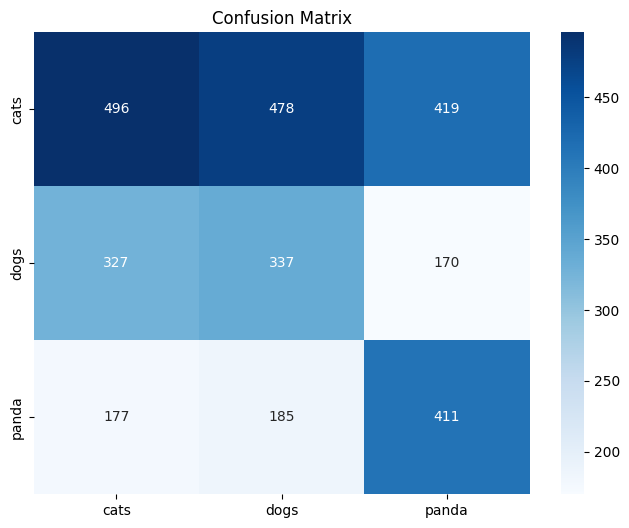

In [11]:

class_names = ['cats', 'dogs', 'panda']
confusion_matrix_df = pd.DataFrame(confusion_matrix,
                                 index=class_names,
                                 columns=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# Clean Mean Accuracy History
cleaned_history = {
    dist: {k: float(v) for k, v in k_vals.items()}
    for dist, k_vals in history.items()
}

# Clean Top-N Predictions
cleaned_top_N = [(int(i), float(conf)) for i, conf in top_N]

# Print nicely
print('Mean Accuracy History:', cleaned_history)
print(f'Top-{N} Confident Correct Predictions (Index, Confidence):', cleaned_top_N)


Mean Accuracy History: {'euclidean': {5: 0.3866666666666666, 10: 0.4133333333333334, 15: 0.4066666666666666, 20: 0.43, 25: 0.42666666666666664}, 'manhattan': {5: 0.4066666666666666, 10: 0.4133333333333334, 15: 0.4, 20: 0.42666666666666675, 25: 0.4366666666666667}}
Top-5 Confident Correct Predictions (Index, Confidence): [(236, 1.0), (246, 1.0), (172, 1.0), (16, 1.0), (92, 1.0)]


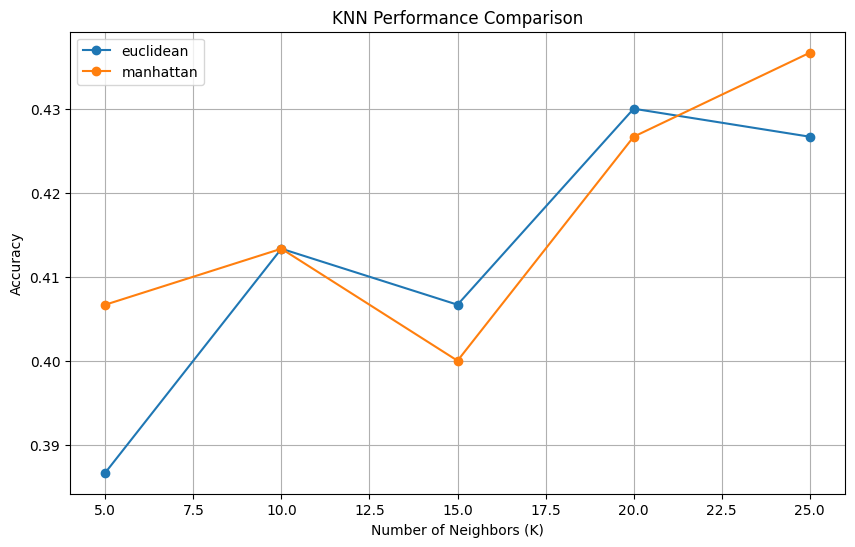

In [13]:
# Visualization
plt.figure(figsize=(10, 6))
for metric in distance_metrics:
    plt.plot(K_values, [history[metric][k] for k in K_values],
             marker='o', label=metric)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('KNN Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()


## Discussion

From the performance history and visualizations, it's evident that the `Manhattan (L1)` distance consistently outperforms the `Euclidean (L2)` distance across most values of `K`. For instance, with `K=25`, the accuracy with `L1` reaches `43.67%` compared to `42.67%` with `L2`, and at K=5, L1 yields `40.67%` while L2 drops slightly to `38.67%`. This pattern suggests that the L1 metric is more robust for this dataset, likely because it's less sensitive to outliers and subtle noise in image data. Since image datasets often contain small variations in pixel values that don't significantly impact class identity, L1 distance's behavior of treating each pixel difference equally may help capture essential features more effectively.

Moreover, the overall accuracy remains moderate for both distance metrics, with performance peaking around the middle values of K (such as `K=20` for both metrics). This indicates a balance between underfitting `(small K)` and over-smoothing `(large K)`. The relatively small dataset (only `100` images per `class`) may also limit the KNN classifier's potential, as it relies heavily on available labeled examples.

In [14]:
# Print results
print("Performance History:")
for metric in history:
    print(f"\n{metric.capitalize()} Distance:")
    for k in K_values:
        print(f"K={k}: Accuracy={history[metric][k]:.4f}")

Performance History:

Euclidean Distance:
K=5: Accuracy=0.3867
K=10: Accuracy=0.4133
K=15: Accuracy=0.4067
K=20: Accuracy=0.4300
K=25: Accuracy=0.4267

Manhattan Distance:
K=5: Accuracy=0.4067
K=10: Accuracy=0.4133
K=15: Accuracy=0.4000
K=20: Accuracy=0.4267
K=25: Accuracy=0.4367


## Top 5 confident predictions

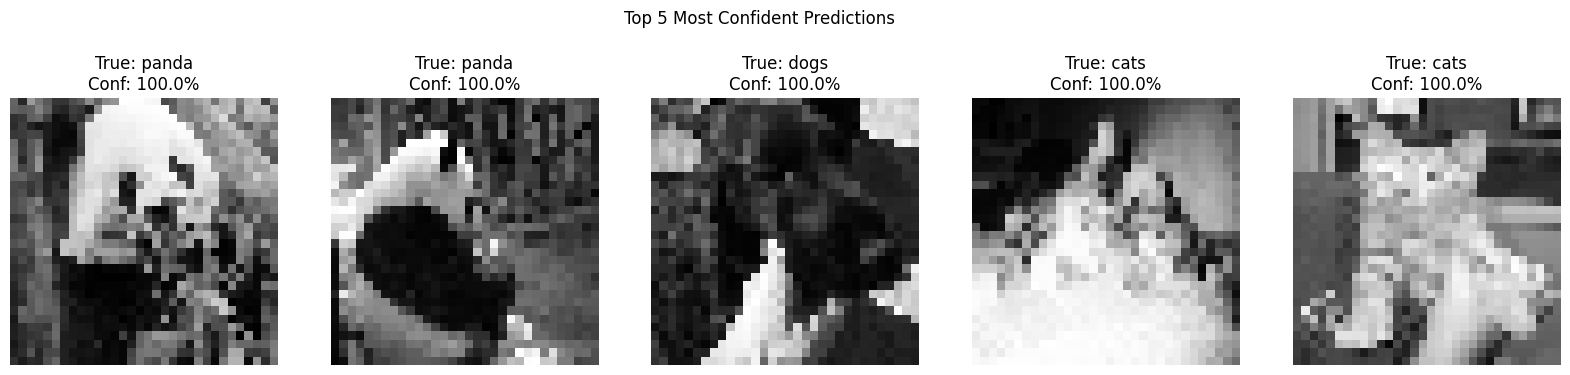

In [15]:

# Top N confident predictions
plt.figure(figsize=(20, 4))
for i, (idx, conf) in enumerate(top_N):
    plt.subplot(1, N, i+1)
    plt.imshow(X[idx], cmap='gray')
    plt.axis('off')
    plt.title(f'True: {class_names[y[idx]]}\nConf: {conf*100:.1f}%')
plt.suptitle(f'Top {N} Most Confident Predictions', y=1.05)
plt.show()
